 ### Restart of Calculations 11/16/2024

Breast Volume

In [20]:
#first let us import the necessary modules
import matplotlib.pyplot as plt
import pydicom
from preprocessing import *
from ispy_utils import *
import numpy as np

In [27]:
#Function to calculate breast volume
def pre_process_dicom(file_path):
    image_array_post, dcm_data_post = read_ispy_mri(file_path)
    image_array_post = zscore_image(normalize_image(image_array_post))
    return image_array_post

def extract_pixel_spacing(file_path):
    # Extracting pixel spacing (x, y dimensions)
    dicom_metadata = pydicom.dcmread(file_path)
    pixel_spacing = dicom_metadata.PixelSpacing  # This is usually a list: [row_spacing, column_spacing]
    slice_thickness = getattr(dicom_metadata, 'SliceThickness', None)  # It's optional in some cases
    print(f"Pixel Spacing: {pixel_spacing}")
    print(f"Slice Thickness: {slice_thickness} mm")
    return pixel_spacing

In [ ]:
#setting file paths
patient_id =[10089, 102011]
file_pre_100899 = ['data/ispy2/ispy2-{}/']
file_post_100899 = ['data/manifest-1722210581008/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/501.000000-ISPY2 Ph1AX VIBRANT-SERIES-03969']

#precontrast image path
file_pre ='data/manifest-1722210581008/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/500.000000-ISPY2 AX VIBRANT-SERIES-52523'

#postcontrast image path
file_post = 'data/manifest-1722210581008/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/501.000000-ISPY2 Ph1AX VIBRANT-SERIES-03969'

pixel_spacing = extract_pixel_spacing(file_post + "/1-042.dcm")

# Extracting pixel spacing (x, y dimensions)
#dicom_metadata = pydicom.dcmread(file_post + "/1-042.dcm")
#pixel_spacing = dicom_metadata.PixelSpacing  # This is usually a list: [row_spacing, column_spacing]
#slice_thickness = getattr(dicom_metadata, 'SliceThickness', None)  # It's optional in some cases
#print(f"Pixel Spacing: {pixel_spacing}")
#print(f"Slice Thickness: {slice_thickness} mm")


Pixel Spacing: [0.6641, 0.6641]
Slice Thickness: 2 mm


(-0.5, 511.5, 511.5, -0.5)

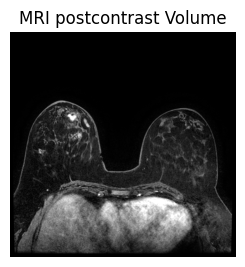

In [ ]:
#apply function from ispymri.py 
image_array_pre, dcm_data_pre = read_ispy_mri(file_pre)
image_array_pre = zscore_image(normalize_image(image_array_pre))
# # saving image - will be used as an input to prediction code
np.save('./volume_compare_dicom/output.npy', image_array_pre)
print(image_array_pre.shape)  #optional

image_array_post, dcm_data_post = read_ispy_mri(file_post)
image_array_post = zscore_image(normalize_image(image_array_post))
np.save('./volume_compare_dicom/output.npy', image_array_post)

#pre-process all dicom files in a loop
#pre_process_dicom(file_post)

#np.save('./volume_compare_dicom/output_100899.npy', image_array_post)

#plotting both the images

# plt.subplot(1,2,1)
# plt.title('MRI precontrast Volume')
# plt.imshow(image_array_pre[:,:,41], cmap = 'gray')
# plt.axis('off')

plt.subplot(1,2,2)
plt.title('MRI postcontrast Volume')
plt.imshow(image_array_post[:,:,42], cmap='gray')
plt.axis('off')

#### Below is the line of code that generates a breast mask
 
```python predict.py --target-tissue breast --image ./volume_compare_dicom --save-masks-dir ./volume_compare_mask --model-save-path ./trained_models/breast_model.pth```

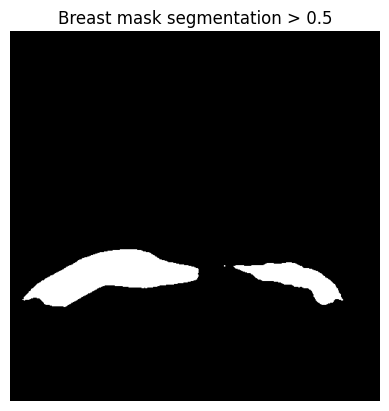

(512, 512, 106)


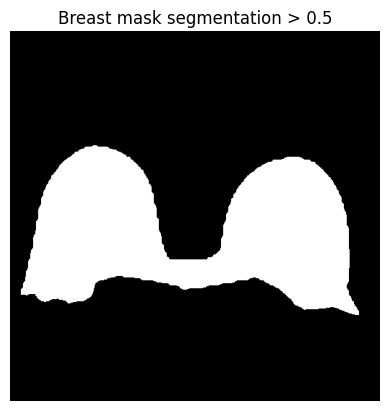

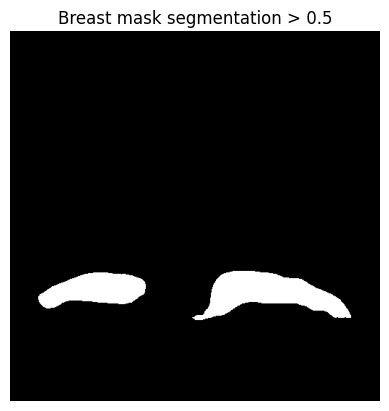

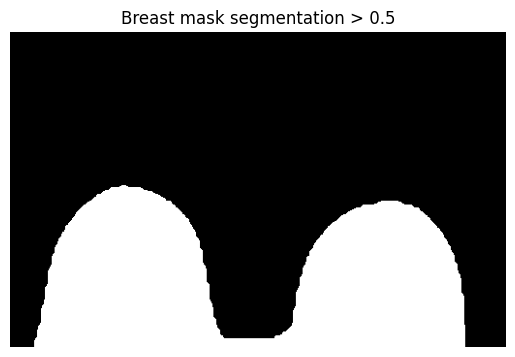

In [17]:


breast_mask_seg = np.load('./volume_compare_mask/output.npy')

#plotting the mask


plt.imshow(breast_mask_seg[:, :, 10] > 0.5, cmap = 'gray')
plt.title('Breast mask segmentation > 0.5')
plt.axis('off')
plt.show()
print(breast_mask_seg.shape)

plt.imshow(breast_mask_seg[:, :, 42] > 0.5, cmap = 'gray')
plt.title('Breast mask segmentation > 0.5')
plt.axis('off')
plt.show()

plt.imshow(breast_mask_seg[:, :, 105] > 0.5, cmap = 'gray')
plt.title('Breast mask segmentation > 0.5')
plt.axis('off')
plt.show()

plt.imshow(breast_mask_seg[0:325,:,42] > 0.5, cmap = 'gray')
plt.title('Breast mask segmentation > 0.5')
plt.axis('off')
plt.show()


In [18]:
#Function to calculate breast volume
def calculate_breast_volume(npy_file, pixel_spacing, slice_thickness):

    dicom_data = np.load(npy_file)

    breast_voxels = np.sum(dicom_data[2,:,:,:] > 0.5)
    print(f"Total Voxels: {breast_voxels} ")

    voxel_volume_mm3 = pixel_spacing[0] * pixel_spacing[1] * slice_thickness

    total_volume_mm3 = breast_voxels * voxel_volume_mm3

    volume_ml = total_volume_mm3 / 1000
    
    return volume_ml

def calculate_mask_volume(npy_file, pixel_spacing, slice_thickness):

    dicom_data = np.load(npy_file)

    breast_voxels = np.sum(dicom_data[0:325,:,:] > 0.5)
    print(f"Total Voxels: {breast_voxels} ")

    voxel_volume_mm3 = pixel_spacing[0] * pixel_spacing[1] * slice_thickness
   
    total_volume_mm3 = breast_voxels * voxel_volume_mm3

    volume_ml = total_volume_mm3 / 1000
    
    return volume_ml

def plot_dicom(dicom_data, slice_index=None, cmap='gray', title='DICOM Image'):
    dicom_data_plot = np.load(dicom_data)
    print(dicom_data_plot.shape)
    plt.imshow(dicom_data_plot[2, :, :, slice_index] > 0.5, cmap = 'gray')
    plt.axis('off')
    plt.show()

In [ ]:
#calculation of breast volume

breast_mask_path = './volume_compare_mask/output.npy'

breast_volume = calculate_mask_volume(breast_mask_path, pixel_spacing, slice_thickness)
print(f"Breast Volume: {breast_volume:.2f} mL")

# around 1400 mL

Total Voxels: 2601163 
Breast Volume: 2294.38 mL


The line of code below runs fgt prediction for pre contrast and post contrast respectively

### post contrast
python predict.py --target-tissue dv --image ./volume_compare_dicom --input-mask ./volume_compare_mask --save-masks-dir ./volume_compare_post --model-save-path ./trained_models/dv_model.pth


FGT

In [ ]:
fgt_post_path = './volume_compare_post/output.npy'
fgt_post_volume = calculate_breast_volume(fgt_post_path, pixel_spacing, slice_thickness)
print(f"Breast Volume: {fgt_post_volume:.2f} mL")

Total Voxels: 97408 
Breast Volume: 85.92 mL


(3, 512, 512, 106)


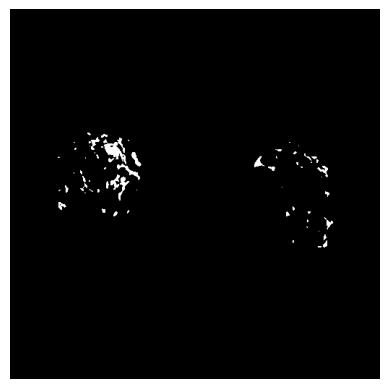

In [ ]:
plot_dicom(fgt_post_path, 42)

In [24]:
#calculation of Ph1 post and pre fgt volume

n_fgt_voxel = np.sum(fgt_data_post > 0.5)
print(n_fgt_voxel)

print((n_fgt_voxel*voxel_volume_mm3))

27785818
24508692.494833164
